In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib notebook
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch

import os
import sys
sys.path.append("../src") if "../src" not in sys.path else None 

# custom imports
from methods import *
from GenericDNN import GenericDNN

In [3]:
# choose dataset to use
dataset_name = 'yacht.txt'
datasets_path = '../datasets/'
dataset_path = datasets_path + dataset_name

# print the name of all the different datasets
import pprint
dataset_names = os.listdir('../datasets/')
# datasets are .txt files - remove non-.txt files
for dataset_name in dataset_names:
    if dataset_name.split('.')[-1] != 'txt':
        dataset_names.remove(dataset_name)
pprint.pprint(dataset_names)

['protein.txt',
 'boston_housing.txt',
 'energy_heating_load.txt',
 'year_prediction_msd.txt',
 'power.txt',
 'concrete.txt',
 'wine.txt',
 'yacht.txt',
 'naval_compressor_decay.txt',
 'kin8nm.txt']


In [4]:
if verbose_datasets:=True:
    # print ALL dataset shapes
    datasets_stats = []
    for dataset_name in dataset_names:
        (X_train, y_train), (X_test, y_test) = load_data(datasets_path + dataset_name)
        datasets_stats.append([dataset_name,X_train.shape, y_train.shape, X_test.shape, y_test.shape])
    pprint.pprint(datasets_stats)

(X_train, y_train), (X_test, y_test) = load_data(dataset_path)
pprint.pprint(f"dataset_name={dataset_path.split('/')[-1]}, {X_train.shape=}, \
              {y_train.shape=}, {X_test.shape=}, {y_test.shape=}")

[['protein.txt', (41157, 9), (41157,), (4573, 9), (4573,)],
 ['boston_housing.txt', (455, 13), (455,), (51, 13), (51,)],
 ['energy_heating_load.txt', (691, 8), (691,), (77, 8), (77,)],
 ['year_prediction_msd.txt', (463810, 90), (463810,), (51535, 90), (51535,)],
 ['power.txt', (8611, 4), (8611,), (957, 4), (957,)],
 ['concrete.txt', (927, 8), (927,), (103, 8), (103,)],
 ['wine.txt', (1439, 11), (1439,), (160, 11), (160,)],
 ['yacht.txt', (277, 6), (277,), (31, 6), (31,)],
 ['naval_compressor_decay.txt', (10740, 16), (10740,), (1194, 16), (1194,)],
 ['kin8nm.txt', (7372, 8), (7372,), (820, 8), (820,)]]
('dataset_name=yacht.txt, X_train.shape=(277, 6),               '
 'y_train.shape=(277,), X_test.shape=(31, 6), y_test.shape=(31,)')


# Initialise Model, Optimizer and Loss-func

In [5]:
trainloader = torch.utils.data.DataLoader(Dataset(X_train, y_train, dataset_name.split('.')[0]), 
                                         batch_size:=32, shuffle:=True)

net = GenericDNN(input_size:=X_train.shape[-1], hidden_size:=input_size, output_size:=1)

criterion = torch.nn.MSELoss()
optimizer = optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

In [6]:
loss_history = []
for epoch in range(num_epochs:=1000):  # loop over the dataset multiple times
    
    running_loss = 0.0
    for i, data in enumerate(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Cumulative Moving Average (CMA) of loss - could instead just use len(trainloader)
        running_loss = (loss.item() + (i+1) * running_loss) / (i+2)
    loss_history.append(running_loss)

# Plot loss, and predictions alongside ground truth

Text(0.5, 1.0, 'Loss History')

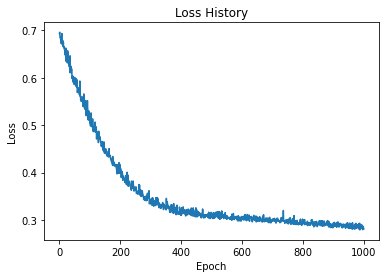

In [7]:
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss History")

Text(0.5, 0.98, 'True vs Predicted')

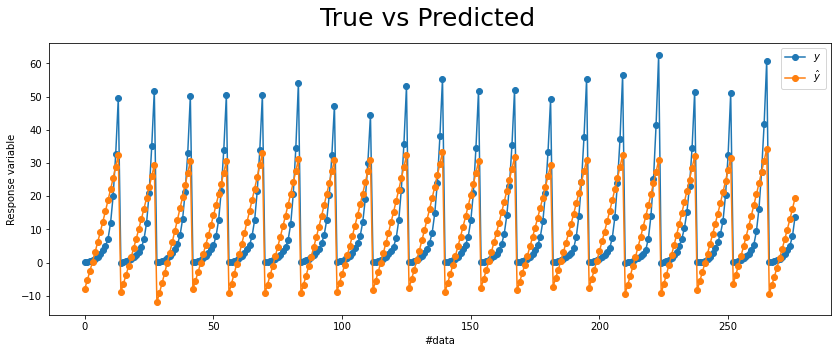

In [11]:
# model prediction
preds = net(trainloader.dataset[:][0]).detach().numpy()[:,0] # forward dataset
preds = preds * trainloader.dataset.stdy + trainloader.dataset.muy # rescale

# plotting
fig, ax = plt.subplots(figsize=(14,5))
ax.plot(y_train, "-o", label="$y$")
ax.plot(preds, "-o", label="$\hat{y}$")
ax.set_xlabel("#data")
ax.set_ylabel("Response variable")
ax.legend()
fig.suptitle("True vs Predicted", size=25)